In [ ]:
# Logistical Regression Deep Neural Networks Using T4 GPU
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

dataset = MNIST(root='data/', download=True, transform=transforms.ToTensor())
len(dataset)

60000

Label: 5


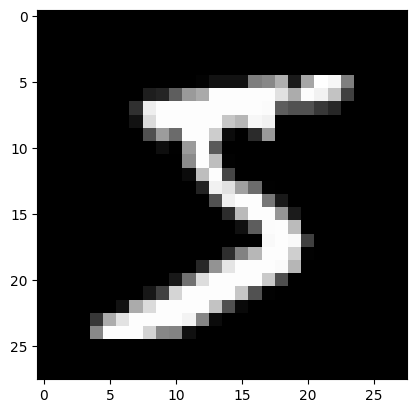

In [ ]:
%matplotlib inline

img, label = dataset[0]
img.shape, label
plt.imshow(img[0], cmap='gray')
# plt.imshow(img.squeeze(), cmap='gray')
print('Label:', label)

In [ ]:
img_tensor, label = dataset[0]
print(img_tensor.shape, 'Label:',label)
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor))
print(torch.min(img_tensor))

torch.Size([1, 28, 28]) Label: 5
tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.)
tensor(0.)


In [ ]:
def split_indices(n, val_pct):
    n_val = int(n*val_pct) # size of validation set, n=60000 & val_pct=0.1
    idxs = np.random.permutation(n) # create random permutation of 0 to n-1
    return idxs[n_val:], idxs[:n_val] # pick first n_val indices for validation set

In [ ]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)
print(len(train_indices), len(val_indices))
print('Sample train indices', train_indices[:10])
print('Sample val indices', val_indices[:10])

48000 12000
Sample train indices [32326 28873 10282 33110 20916 29388 44149 43465 38613 38562]
Sample val indices [ 2739 32796  6568 13678 23159 36690  5991 21855 42059 14106]


In [ ]:
batch_size = 100
#training
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)
#validation
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size, sampler=valid_sampler)

In [ ]:

input_size = 28 * 28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)
print(model.weight.shape)
model.weight

# To improve upon classical logistic, neural network adds one hidden layer.
## 1. Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities),
## this uses 2 nn.Linear objects. Each of these is a network layer.
## 2. The first layer (hidden layer) transforms input matrix of shap batch_size x 784 into an inermediate output matrix of shape
## batch size x hidden_size, where hidden_size is a preconfigured parameter, e.g. 32 or 64.
## 3. Intermediate outputs are then passed into a non-linear Activation Function, which operates on individual elems of the output matrix.
## 4. Result of Activation Function, also of size batch_size x hidden_size, is passed into the second layer (outputs layer),
## which transforms it into a matrix of size batch_size x 10, identical to the output of the classical logistic regression model.


torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0193,  0.0097, -0.0245,  ...,  0.0095,  0.0101,  0.0092],
        [-0.0251, -0.0302,  0.0336,  ...,  0.0261, -0.0059,  0.0237],
        [ 0.0266, -0.0288, -0.0302,  ...,  0.0089,  0.0096, -0.0200],
        ...,
        [ 0.0336, -0.0313, -0.0137,  ..., -0.0273, -0.0068,  0.0296],
        [ 0.0192,  0.0014, -0.0352,  ..., -0.0116,  0.0247, -0.0094],
        [-0.0282,  0.0316, -0.0208,  ...,  0.0163,  0.0312,  0.0304]],
       requires_grad=True)

In [ ]:
for xb, yb in train_dl:
    print(xb.shape)
    break

torch.Size([100, 1, 28, 28])


In [ ]:
for xb, yb in train_dl:
    # xb = xb.view(100, 784) # torch.Size([100,784])
    # xb = xb.view(xb.size(0),784) # torch.Size([100,784])
    xb = xb.view(xb.size(0),-1) # torch.Size([100,784])
    print(xb.shape)
    break

torch.Size([100, 784])


In [ ]:
## 5. The Activation Function used here is "Rectified Linear Unit" or "ReLU", with simple formula:
## relu(x) = max(0,x) i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged
## This is done by extending the nn.Module class as done with classical logistic

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class MnistModel(nn.Module):
 # """ Feedforward neural network with 1 hidden layer """
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # Hidden Layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply Activation Function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

In [ ]:
# Activation Function be like:
t = torch.tensor([0,.2,-0.3])
F.relu(t)

tensor([0.0000, 0.2000, 0.0000])

In [ ]:
# Model with Hidden Layer of 32 activations
input_size = 28 * 28 # 784
num_classes = 10
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
print(model.linear1.weight.shape, model.linear1.bias.shape)


torch.Size([32, 784]) torch.Size([32])


In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss: ', loss.item())
    break

print('outputs.shape: ', outputs.shape)
print('Sample outputs: \n', F.softmax(outputs[:2].data))
print('Sample outputs [SUM]: \n', torch.sum(F.softmax(outputs)))

torch.Size([100, 1, 28, 28])
Loss:  2.2920312881469727
outputs.shape:  torch.Size([100, 10])
Sample outputs: 
 tensor([[0.1141, 0.1021, 0.0904, 0.1002, 0.1045, 0.0941, 0.0976, 0.0940, 0.1088,
         0.0941],
        [0.1146, 0.1126, 0.0853, 0.0925, 0.1096, 0.0936, 0.0889, 0.1000, 0.1079,
         0.0949]])
Sample outputs [SUM]: 
 tensor(100.0000, grad_fn=<SumBackward0>)


<ipython-input-15-53d953a6bbb8>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('Sample outputs: \n', F.softmax(outputs[:2].data))
<ipython-input-15-53d953a6bbb8>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('Sample outputs [SUM]: \n', torch.sum(F.softmax(outputs)))


In [ ]:
# GPU - optimizing  performance on expensive matrix operations on floating point numbers
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device
# device(type='cuda')

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [ ]:
to_device(torch.tensor([1,2,3,4]), device)

tensor([1, 2, 3, 4], device='cuda:0')

In [ ]:
# DeviceDataLoader class wrap existing data loaders and move data to selected device, as batches are accessed.
# No need to extend existing class to create PyTorch dataloader.
# All needed is an __iter__ method to retrieve batches of data and a __len__ method to get the number of batches.
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
#
for xb, yb in valid_dl:
    print('xb.device:', xb.device)
    print('yb :', yb)
    break

xb.device: cuda:0
yb : tensor([6, 4, 8, 6, 8, 7, 0, 2, 6, 6, 0, 4, 8, 6, 1, 2, 6, 7, 2, 4, 2, 1, 5, 7,
        8, 9, 1, 3, 6, 2, 6, 2, 6, 1, 1, 0, 1, 9, 5, 0, 4, 6, 1, 1, 3, 4, 8, 4,
        6, 2, 1, 9, 8, 4, 0, 3, 4, 2, 2, 5, 8, 0, 2, 7, 1, 7, 3, 6, 3, 8, 9, 2,
        4, 9, 7, 6, 8, 1, 8, 5, 4, 5, 3, 3, 7, 6, 0, 1, 4, 5, 2, 3, 5, 7, 0, 2,
        3, 1, 3, 6], device='cuda:0')


In [ ]:
### 1. calcualtes loss for batch of data,
### 2. optionally performs gradient descent update step if optimizer provided,
### 3. optionally coputes a metric of accuracy using preds and targets
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)  # generate predictions
    loss = loss_func(preds, yb)  # calculate loss
    if opt is not None:
        loss.backward() # compute gradients
        opt.step() # update parameters
        opt.zero_grad() # reset gradients
    metric_result = None
    if metric is not None: #compute metric
      metric_result = metric(preds,yb)

    return loss.item(), len(xb), metric_result

In [ ]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad(): # pass each batch through model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results) # separate losses, counts and metrics
        total = np.sum(nums) #total size of dataset
        avg_loss = np.sum(np.multiply(losses, nums)) / total # average loss
        avg_metric = None
        if metric is not None:  # avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [ ]:
def fit(epochs, lr, loss_fn, train_dl,
        valid_dl, metric=None, opt_fn=None):
  losses, metrics = [], []
  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = torch.optim.SGD(model.parameters(), lr=lr)

  for epoch in range(epochs):
    # Training
    for xb, yb in train_dl:
      loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

    # Evaluation
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    # Record the loss & metric
    losses.append(val_loss)
    metrics.append(val_metric)

    # Print progress
    if metric is None:
      print('Epoch [{}/{}], loss: {:.4f}'.format(epoch+1, epochs, val_loss))
    else:
      print('Epoch [{}/{}], loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

  return losses, metrics

1. _____Generate predictions
2. _____Calculate the loss
3. _____Compute gradients with respect to Weights and Biases
4. _____[learning-rate] Adjust the weights by subtracting a small quantity proportional to the gradient
5. ____Reset gradients to zero

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss,  val_acc))

Loss: 2.3117, Accuracy: 0.0911


In [ ]:
losses1, metrics1 = fit(5, 0.5, F.cross_entropy, train_dl, valid_dl, accuracy) # w GPU ~.96

Epoch [1/5], loss: 0.2098, accuracy: 0.9342
Epoch [2/5], loss: 0.1538, accuracy: 0.9529
Epoch [3/5], loss: 0.1512, accuracy: 0.9534
Epoch [4/5], loss: 0.1157, accuracy: 0.9623
Epoch [5/5], loss: 0.1140, accuracy: 0.9645


In [ ]:
# losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy, train_dl, valid_dl, accuracy)
losses2, metrics2 = fit(5, 0.1, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], loss: 0.1015, accuracy: 0.9673
Epoch [2/5], loss: 0.0991, accuracy: 0.9677
Epoch [3/5], loss: 0.0985, accuracy: 0.9680
Epoch [4/5], loss: 0.0978, accuracy: 0.9682
Epoch [5/5], loss: 0.0972, accuracy: 0.9682


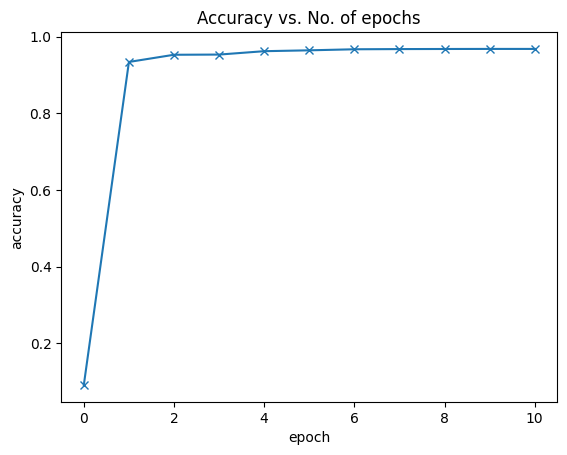

In [ ]:
accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');
#